In [ ]:
#install Required Libraries
pip install seqeval

In [4]:
#install Required Libraries

from datasets import load_metric, load_dataset
from datasets import ClassLabel, Sequence
import random
import pandas as pd
from IPython.display import display, HTML
import numpy as np
import transformers
from transformers import AutoTokenizer, TrainingArguments
from transformers import DataCollatorForTokenClassification, Trainer
from transformers import AutoModelForTokenClassification

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [5]:
datasets = load_dataset("cfilt/HiNER-collapsed") #Load the required dataset

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset hi_ner_collapsed_config downloaded and prepared to /root/.cache/huggingface/datasets/cfilt___hi_ner_collapsed_config/HiNER-Collapsed/0.0.2/fa4c99b4cefed1144a9c7da5e3d85737ead950f0e8db723d1bf108fc7613b493. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
label_list = datasets["train"].features[f"ner_tags"].feature.names #Load features 

In [7]:
def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
        elif isinstance(typ, Sequence) and isinstance(typ.feature, ClassLabel):
            df[column] = df[column].transform(lambda x: [typ.feature.names[i] for i in x])
    display(HTML(df.to_html()))

In [8]:
task = "ner" 
model_checkpoint = "xlm-roberta-large"   #Name of the model used 
batch_size = 4     #Change it according to your gpu 

In [9]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)
example = datasets["train"][4]

In [10]:
tokenized_input = tokenizer(example["tokens"], is_split_into_words=True)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])

In [11]:
label_all_tokens = True
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True) 

    labels = []
    for i, label in enumerate(examples[f"{task}_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # Set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [12]:
tokenized_datasets = datasets.map(tokenize_and_align_labels, batched=True)
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list))
model_name = model_checkpoint.split("/")[-1]
args = TrainingArguments(
    f"{model_name}-finetuned-{task}",
    evaluation_strategy ='steps',
    eval_steps = 7000,
    save_total_limit = 3,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=4,
    num_train_epochs=4,
    weight_decay=0.001,
    save_steps=35000,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True
)

  0%|          | 0/76 [00:00<?, ?ba/s]

  0%|          | 0/11 [00:00<?, ?ba/s]

  0%|          | 0/22 [00:00<?, ?ba/s]

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaForTokenClassification: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to 

In [13]:
data_collator = DataCollatorForTokenClassification(tokenizer)
metric = load_metric("seqeval")
labels = [label_list[i] for i in example[f"{task}_tags"]]
metric.compute(predictions=[labels], references=[labels])

{'ORG': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'overall_precision': 1.0,
 'overall_recall': 1.0,
 'overall_f1': 1.0,
 'overall_accuracy': 1.0}

In [14]:
import numpy as np

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [15]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [16]:
trainer.train()
trainer.evaluate()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
7000,0.101700,0.116899,0.863053,0.891334,0.876966,0.973616
14000,0.109000,0.110428,0.865604,0.892286,0.878742,0.973350
21000,0.080800,0.115217,0.858226,0.899685,0.878467,0.972954
28000,0.080900,0.091456,0.869077,0.904188,0.886285,0.974978
35000,0.076400,0.093718,0.885197,0.895414,0.890276,0.976603
42000,0.063000,0.094803,0.890315,0.893195,0.891752,0.976576
49000,0.061700,0.093342,0.889763,0.901820,0.895751,0.977596
56000,0.059200,0.096039,0.888002,0.907846,0.897814,0.977972
63000,0.048000,0.107346,0.885625,0.905097,0.895255,0.977584
70000,0.041400,0.102453,0.889219,0.904991,0.897036,0.977894


{'eval_loss': 0.10245311260223389,
 'eval_precision': 0.8892189447444953,
 'eval_recall': 0.904991437813154,
 'eval_f1': 0.897035865089427,
 'eval_accuracy': 0.9778943256934485,
 'eval_runtime': 105.3482,
 'eval_samples_per_second': 103.001,
 'eval_steps_per_second': 25.753,
 'epoch': 4.0}

In [43]:
predictions, labels, _ = trainer.predict(tokenized_datasets["test"])
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results = metric.compute(predictions=true_predictions, references=true_labels)
results

{'LOC': {'precision': 0.8458656007994004,
  'recall': 0.8662061908416475,
  'f1': 0.8559150657229525,
  'number': 11727},
 'ORG': {'precision': 0.9088841377428013,
  'recall': 0.9209778283115406,
  'f1': 0.9148910189877281,
  'number': 65083},
 'PER': {'precision': 0.8622416364798636,
  'recall': 0.8893406593406593,
  'f1': 0.8755815211511414,
  'number': 18200},
 'overall_precision': 0.8920086839656777,
 'overall_recall': 0.908157036101463,
 'overall_f1': 0.9000104307916971,
 'overall_accuracy': 0.9782534494143038}

In [ ]:
trainer.save_model('collapsed_xlm_r_large_finetuned_ner')  #Name it according to your trainedd model

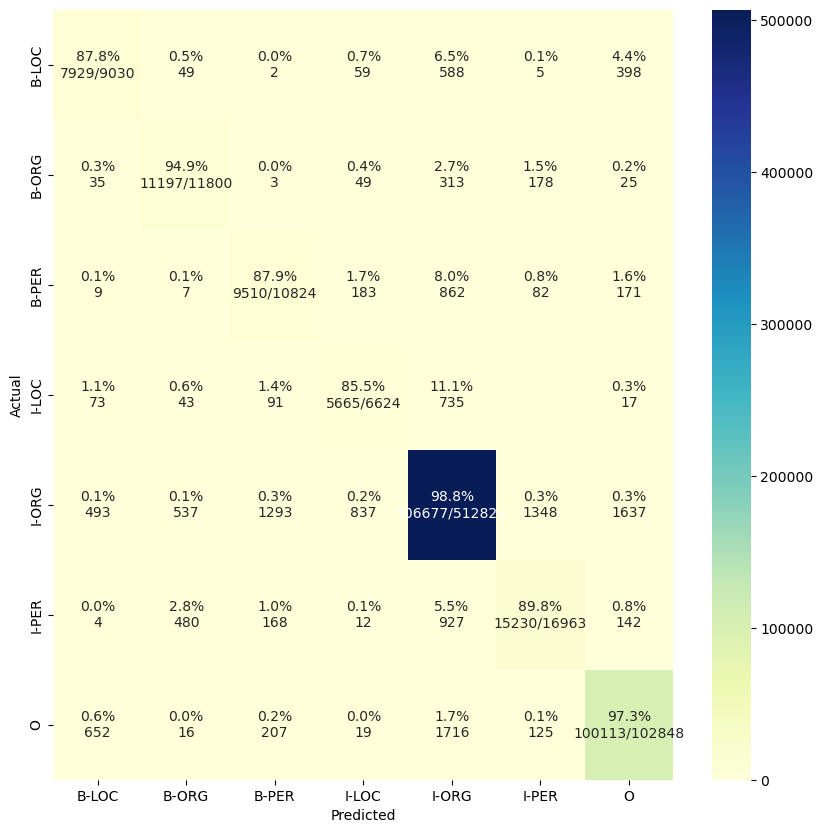

In [25]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

true_labels_flat = [item for sublist in true_labels for item in sublist]
true_predictions_flat = [item for sublist in true_predictions for item in sublist]


def plot_cm(y_true, y_pred, figsize=(10,10)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax).figure.savefig('file.png')
    
plot_cm(true_labels_flat, true_predictions_flat)